In [85]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

%matplotlib inline

### <p style="text-align: center; color: green;">Motion Compensation Block Based</p>  

#### (A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward  par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par  blocs entre F1 et F2.

In [86]:
OPTI_SLICING = 8
SEARCH_DIST_PIXEL = 4

BLOCK_LEN = 12
SEARCH_DIST_BLOCK = 18

LOOP_IMAGES = 1

In [87]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def estimate(deltaIntensity, dist):
    return 2 * deltaIntensity + dist / SEARCH_DIST_PIXEL

class Image:

    def __init__(self, pathImg):
        self.img = cv2.imread(pathImg)
        self.grayImage = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.height, self.width = self.grayImage.shape[:2]

    # (A) Pixel-wise
    def differencePixelWise(self, other):
        vectors = np.full((self.height, self.width, 2), np.inf)
        # Get the indexes of the pixels to loop through
        y_idx = np.arange(0, self.height, OPTI_SLICING)
        x_idx = np.arange(0, self.width, OPTI_SLICING)

        # Get the indexes of the search area
        y2_idx, x2_idx = np.indices((2 * SEARCH_DIST_PIXEL + 1, 2 * SEARCH_DIST_PIXEL + 1))
        y2_idx -= SEARCH_DIST_PIXEL
        x2_idx -= SEARCH_DIST_PIXEL
        
        for i in range(len(y_idx)):
            for j in range(len(x_idx)):
                y2_idx_tmp = y2_idx + y_idx[i]
                x2_idx_tmp = x2_idx + x_idx[j]
                # Make sure the indexes are in the image
                y2_idx_tmp = np.clip(y2_idx_tmp, 0, self.height-1)
                x2_idx_tmp = np.clip(x2_idx_tmp, 0, self.width-1)
                # Get the intensity of the pixel and the intensity of the pixel in the search area
                intensity1 = self.grayImage[y_idx[i], x_idx[j]]
                intensity2 = other.grayImage[y2_idx_tmp, x2_idx_tmp]
                deltaIntensity = np.abs(intensity2 - intensity1)
                dist = distance(x_idx[j], y_idx[i], x2_idx_tmp, y2_idx_tmp)
                estimation = estimate(deltaIntensity, dist)
                # Get the indexes of the minimum value inside estimation
                idx = np.unravel_index(np.argmin(estimation, axis=None), estimation.shape)
                vectors[y_idx[i], x_idx[j], 0] = (x2_idx_tmp[idx] - x_idx[j]) * 2
                vectors[y_idx[i], x_idx[j], 1] = (y2_idx_tmp[idx] - y_idx[i]) * 2
        return vectors


    # (B) Block-wise
    def differenceBlockWise(self, other):
        vectors = np.zeros((self.height, self.width, 2))
        # Loop through all blocks
        for y in range(BLOCK_LEN//2, self.height, BLOCK_LEN):
            for x in range(BLOCK_LEN//2, self.width, BLOCK_LEN):
                # Get the block
                block = self.grayImage[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2]
                # Make sure the block is the right size
                if block.shape != (BLOCK_LEN, BLOCK_LEN):
                    block = cv2.resize(block, (BLOCK_LEN, BLOCK_LEN))
                # Get the search area
                yMoves = np.arange(max(y-SEARCH_DIST_BLOCK, 0), min(y+SEARCH_DIST_BLOCK, self.height))
                xMoves = np.arange(max(x-SEARCH_DIST_BLOCK, 0), min(x+SEARCH_DIST_BLOCK, self.width))

                # Get the differences
                diff = np.zeros((len(yMoves), len(xMoves)))
                for i in range(len(yMoves)):
                    for j in range(len(xMoves)):
                        # Get the block in the search area
                        block2 = other.grayImage[max(yMoves[i]-BLOCK_LEN//2, 0):min(yMoves[i]+BLOCK_LEN//2, self.height), max(xMoves[j]-BLOCK_LEN//2, 0):min(xMoves[j]+BLOCK_LEN//2, self.width)]
                        # Make sure the blocks are the same size for border issues
                        if block2.shape != block.shape:
                            block2 = cv2.resize(block2, (BLOCK_LEN, BLOCK_LEN))
                        
                        # Get the difference using the estimation function
                        diff[i, j] = np.sum(2 * np.abs(block2 - block) + distance(x, y, xMoves[j], yMoves[i]))

                # Get the index of the minimum difference
                idx = np.unravel_index(np.argmin(diff, axis=None), diff.shape)
                # Get the vector
                vectors[y, x, 0] = (xMoves[idx[1]] - x)
                vectors[y, x, 1] = (yMoves[idx[0]] - y)
        return vectors

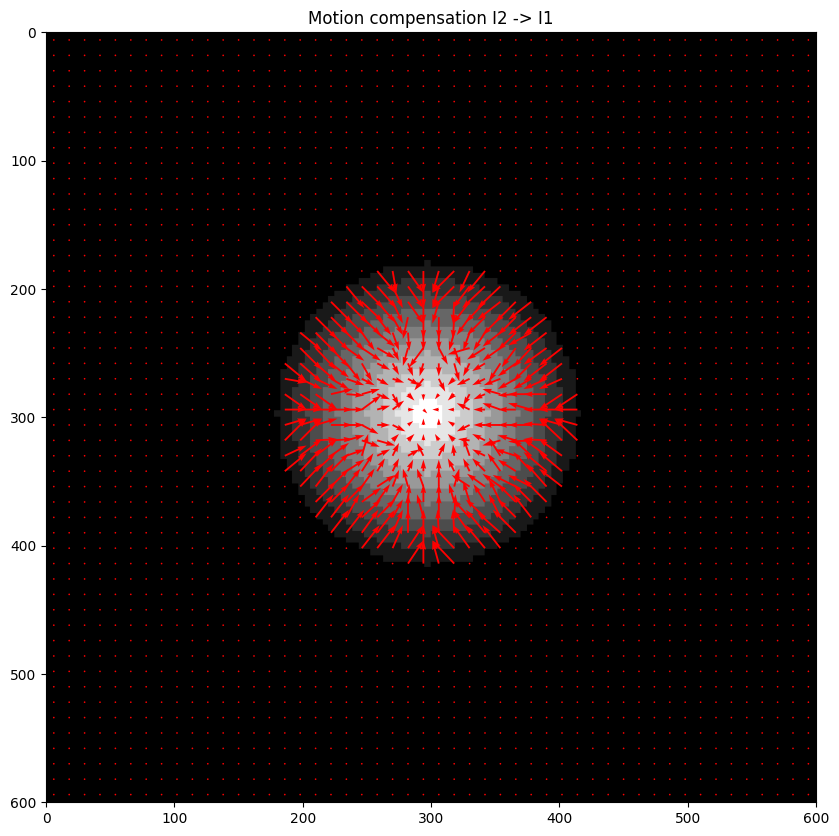

In [88]:
# create a new figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Charger les deux images
img1 = Image('1.png')
img2 = Image('2.png')

ax.clear()
ax.imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))

# Calcul des vecteurs de mouvement
vectors = img2.differenceBlockWise(img1)

# draw the vectors using quiver
ax.quiver(np.arange(BLOCK_LEN // 2, img1.width, BLOCK_LEN), np.arange(BLOCK_LEN // 2, img1.height, BLOCK_LEN),
            vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 0], vectors[BLOCK_LEN // 2::BLOCK_LEN, BLOCK_LEN // 2::BLOCK_LEN, 1],
            angles='xy', scale_units='xy', scale=1, color='r')

# set the x and y limits of the plot
ax.set_xlim([0, img1.width])
ax.set_ylim([0, img1.height])
ax.set_title('Motion compensation I2 -> I1')

# Reverse the image
ax.invert_yaxis()

# show the plot
plt.show()

#### (B) Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ?

Il nous faut les vecteurs partant de la frame F2 pour pouvoir reconstruire celle-ci. Si nous prenions des vecteurs partant de la frame F1 avec la ME forward il y aurait un overlaps des blocs et donc des 'trous' dans la frame reconstruite causés par le fait que les blocs bougés par rapport aux vecteurs ne correspondront pas exactement aux blocs dans F2 . Alors que faire de la ME backward garantit en prenant l'opposé des vecteurs de faire bouger des blocs qui combleront l'image recomposée depuis F1.

#### (C) Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

In [89]:
def compensation(vectors, img1, BLOCK_LEN):
    '''
        Compensate the image 2 from image 1 using the movement vectors 
    '''
    # Create a new image
    compensated = np.zeros((img1.height, img1.width, 3), dtype=np.uint8)
    # Loop through all the pixels
    for y in range(BLOCK_LEN//2, img1.height, BLOCK_LEN):
        for x in range(BLOCK_LEN//2, img1.width, BLOCK_LEN):
            compensated[y-BLOCK_LEN//2:y+BLOCK_LEN//2, x-BLOCK_LEN//2:x+BLOCK_LEN//2] = img1.img[
                y+vectors[y, x, 1]-BLOCK_LEN//2:y+vectors[y, x, 1]+BLOCK_LEN//2,
                x+vectors[y, x, 0]-BLOCK_LEN//2:x+vectors[y, x, 0]+BLOCK_LEN//2
            ]
    return compensated

In [90]:
def plotting3Axes(img1, img2, compensated):
    '''
        Plot the 3 images in 3 axes
    '''
    # create a new figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    # clear the axes
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    # show the images
    ax[0].imshow(cv2.cvtColor(img1.img, cv2.COLOR_BGR2RGB))
    ax[2].imshow(cv2.cvtColor(img2.img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(compensated, cv2.COLOR_BGR2RGB))

    # set the titles
    ax[0].set_title('Image 1')
    ax[2].set_title('Image 2')
    ax[1].set_title('Compensated')

    # show the plot
    plt.show()

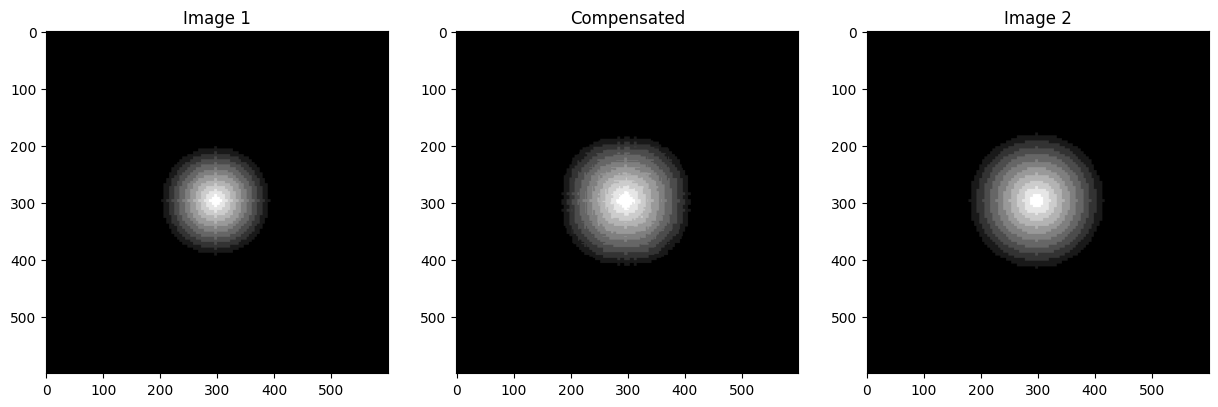

In [91]:
# Make sure the vectors are integers
vectors = vectors.astype(np.int32)
# Create a new img with the same shape as img2
img2_compensated = compensation(vectors, img1, BLOCK_LEN)

plotting3Axes(img1, img2, img2_compensated)

Here is the MSE between `img2` and `img2_compensated`

In [92]:
# Get the mean squared error between img2 and img2_compensated
mse = np.mean((img2.img - img2_compensated) ** 2)
print('MSE:', mse)

MSE: 2.2723305555555555


Regardons les différences d'intensité entre les 2 images en montrant l'image des différences

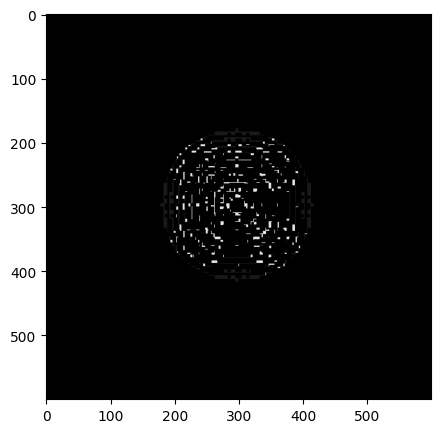

In [93]:
# Difference between img2 and img2_compensated
diff = img2.img - img2_compensated

# Create a new figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Draw the difference
ax.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))

plt.show()

#### (D) Supposant que l’on n’aura plus accés à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

Les 3 données dont on aura besoin seront :

- Vecteurs de mouvement pour effectuer la compensation
- L'image I1
- Notre image de différence entre I2 et notre compensation de I2

#### (E) Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

En utilisant seulement les 3 données décrites ci-dessus :

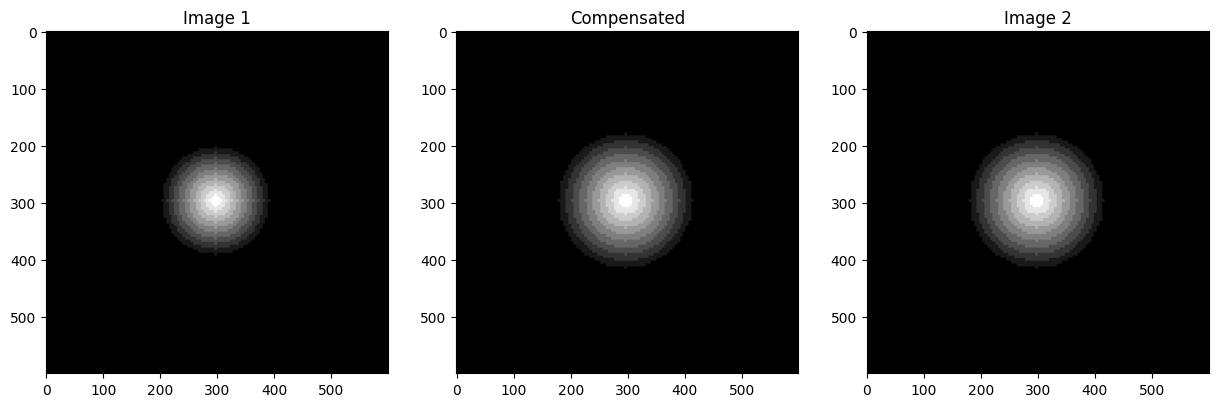

In [94]:
# Create the compensated image
img2_compensated = compensation(vectors, img1, BLOCK_LEN)
# Add the difference
img2_compensated = img2_compensated + diff

plotting3Axes(img1, img2, img2_compensated)

In [95]:
# Compute MSE
mse = np.mean((img2.img - img2_compensated) ** 2)
print('MSE:', mse)

MSE: 0.0


La MSE est maintenant nulle, nous avons une parfaite reconstruction de l'image 2 à partir des 3 données.

#### (F) Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

Essayons de limiter les données provenant de l'image de différence en éliminant les petites valeurs.

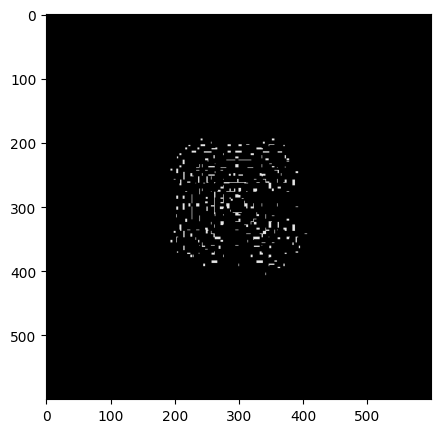

In [96]:
diff2 = diff.copy()
diff2[diff2 < 50] = 0

# Plot the difference
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(diff2, cv2.COLOR_BGR2RGB))
plt.show()

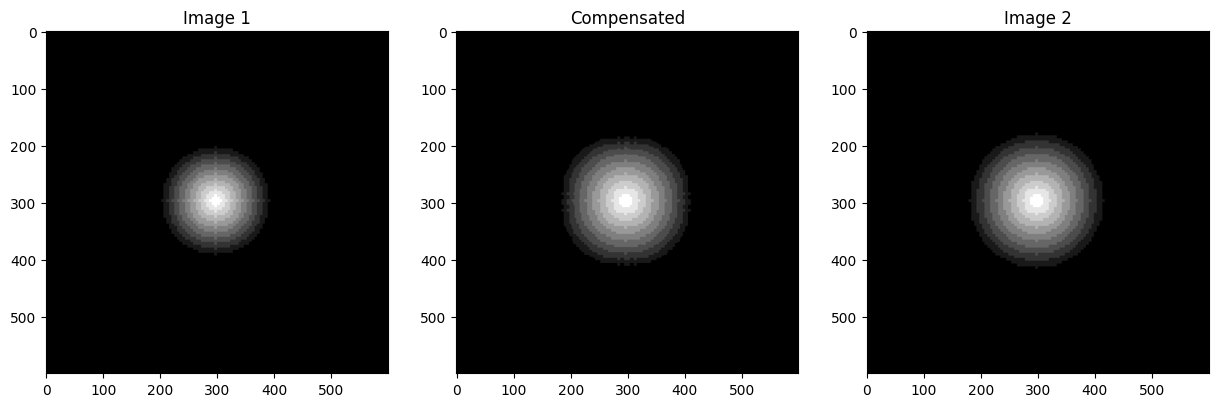

In [97]:
# Create the compensated image
compensated = compensation(vectors, img1, BLOCK_LEN)
# Add the difference
compensated = compensated + diff2

plotting3Axes(img1, img2, compensated)

In [98]:
# Compute MSE
mse = np.mean((img2.img - compensated) ** 2)
print('MSE:', mse)

MSE: 1.1768027777777779


Cette solution divise l'erreur (MSE) par deux entre la ressemblance de l'image compensé avec l'image réelle. Cependant, nous voyons bien une différence entre les deux images.

Une autre façon de faire serait de rapprocher chaque valeur égale sur l'image de différence en une seule valeur (plus petite), puis donner le tableau de changement des valeurs et de donner ce tableau (traduction) lors de la reconstruction de l'image comme une 4e données.  
Exemple: les cases ayant pour valeur 25 serait mis à 1 et on ajoutera une ligne dans le tableau (1: 25).

In [104]:
# Print the different values inside the difference
print(np.unique(diff))
uni = np.unique(diff)

[  0  25  26 230 231]


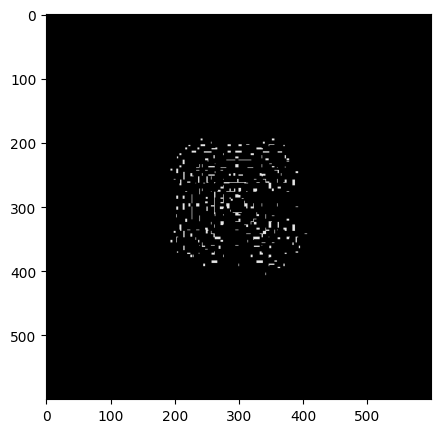

In [105]:
diff3 = diff.copy()
# Make the values inside diff3 equal to the index of the value in uni
for i in range(len(uni)):
    diff3[diff3 == uni[i]] = i
diff3 = diff3.astype(np.uint8)

Actions done when decompressing

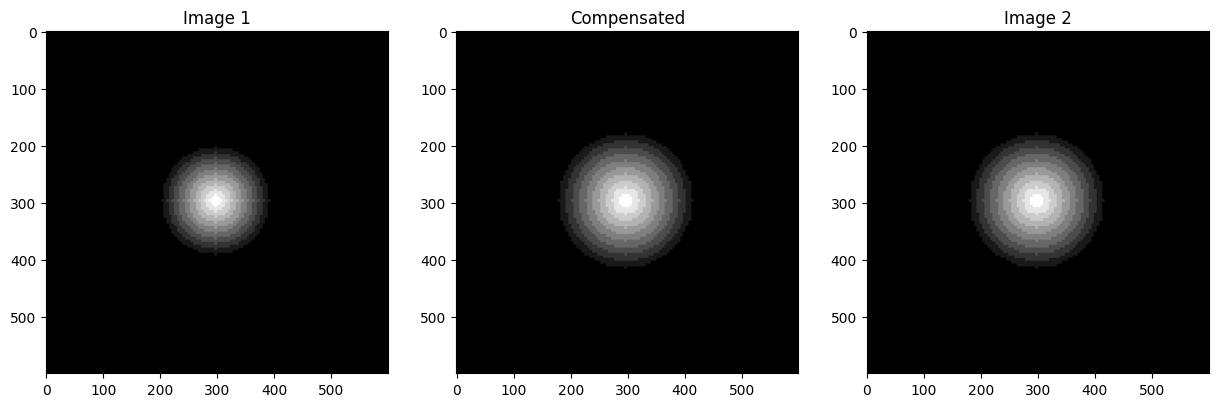

In [107]:
# Create the compensated image
compensated = compensation(vectors, img1, BLOCK_LEN)
# Make the indexes inside diff3 equal to the values in uni
diff3[diff3 != 0] = uni[diff3[diff3 != 0]]
# Add the difference
compensated = compensated + diff3

plotting3Axes(img1, img2, compensated)

In [108]:
# Compute MSE
mse = np.mean((img2.img - compensated) ** 2)
print('MSE:', mse)

MSE: 0.0


#### (G) Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.